# Bootes master catalogue

This notebook presents the merge of the various pristine catalogues to produce HELP mater catalogue on ELAIS-N1.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
decals = Table.read("{}/DECaLS.fits".format(TMP_DIR))
datafusion = Table.read("{}/Datafusion.fits".format(TMP_DIR))
ibis = Table.read("{}/IBIS.fits".format(TMP_DIR))
legacy = Table.read("{}/LegacySurvey.fits".format(TMP_DIR))
ndwfs = Table.read("{}/NDWFS.fits".format(TMP_DIR))
ps1 = Table.read("{}/PS1.fits".format(TMP_DIR))
#sdwfs = Table.read("{}/SDWFS.fits".format(TMP_DIR)) #We use DataFusion instead
uhs = Table.read("{}/UHS.fits".format(TMP_DIR))
zbootes = Table.read("{}/zBootes.fits".format(TMP_DIR))

## II - Merging tables

We first merge the optical catalogues and then add the infrared ones.

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

### PanSTARRS

In [5]:
master_catalogue = ps1
master_catalogue['ps1_ra'].name = 'ra'
master_catalogue['ps1_dec'].name = 'dec'

### Add DECaLS

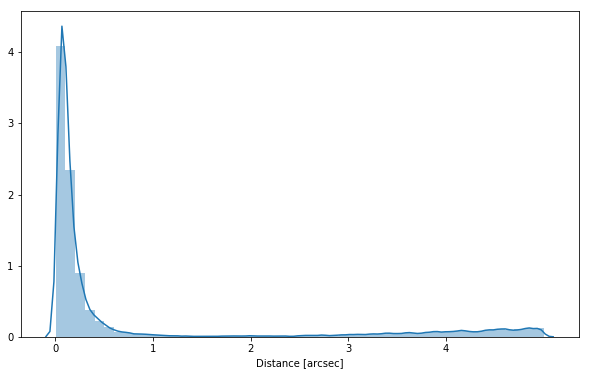

In [6]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(decals['decals_ra'], decals['decals_dec'])
)

In [7]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, decals, "decals_ra", "decals_dec", radius=0.8*u.arcsec)

### Add Legacy Survey

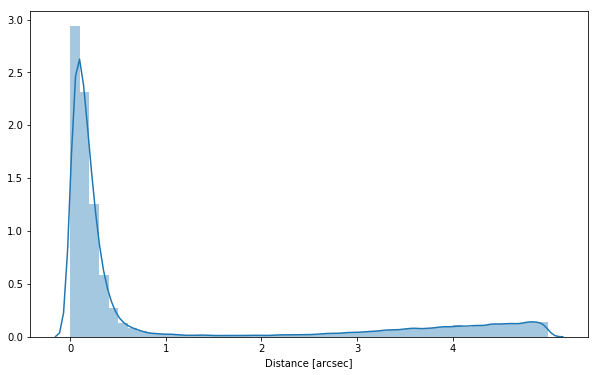

In [8]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(legacy['legacy_ra'], legacy['legacy_dec'])
)

In [9]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, legacy, "legacy_ra", "legacy_dec", radius=0.8*u.arcsec)

### Add IBIS

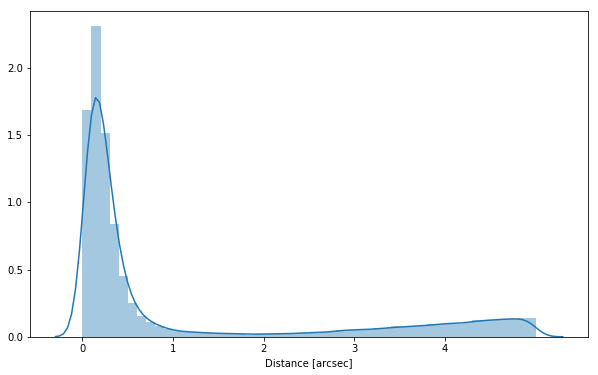

In [10]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(ibis['ibis_ra'], ibis['ibis_dec'])
)

In [11]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, ibis, "ibis_ra", "ibis_dec", radius=0.8*u.arcsec)

### Add NDWFS

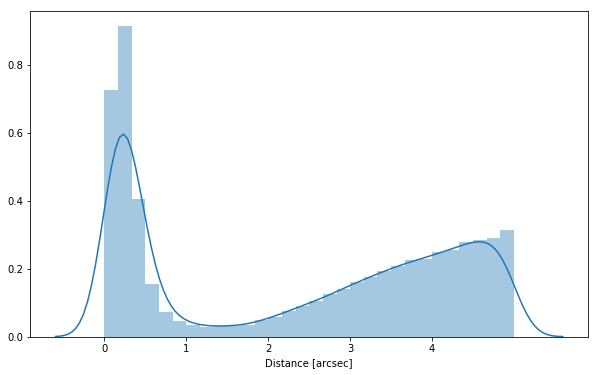

In [12]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(ndwfs['ndwfs_ra'], ndwfs['ndwfs_dec'])
)

In [13]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, ndwfs, "ndwfs_ra", "ndwfs_dec", radius=0.8*u.arcsec)

### Add UHS

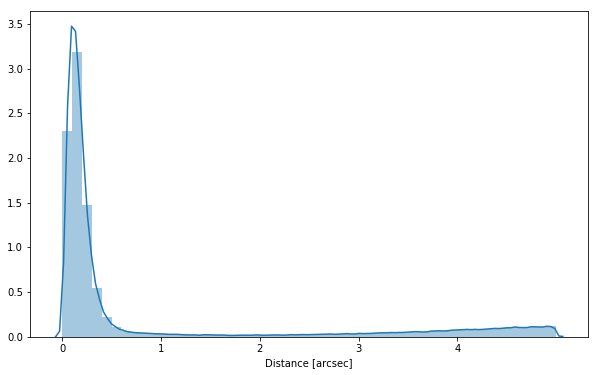

In [14]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(uhs['uhs_ra'], uhs['uhs_dec'])
)

In [15]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, uhs, "uhs_ra", "uhs_dec", radius=0.8*u.arcsec)

### Add zBootes

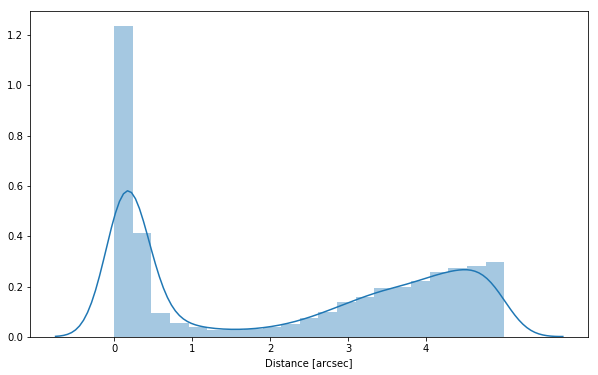

In [16]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(zbootes['zbootes_ra'], zbootes['zbootes_dec'])
)

In [17]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, zbootes, "zbootes_ra", "zbootes_dec", radius=0.8*u.arcsec)

### Add SDWFS

nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(sdwfs['sdwfs_ra'], sdwfs['sdwfs_dec'])
)

#Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, sdwfs, "sdwfs_ra", "sdwfs_dec", radius=1.*u.arcsec)

### Add Datafusion

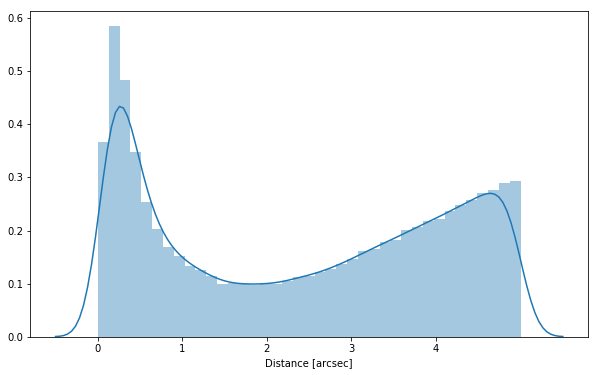

In [20]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(datafusion['datafusion_ra'], datafusion['datafusion_dec'])
)

In [21]:
# Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, datafusion, "datafusion_ra", "datafusion_dec", radius=1.*u.arcsec)

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [22]:
for col in master_catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [23]:
master_catalogue[:10].show_in_notebook()

idx,ps1_id,ra,dec,m_ap_gpc1_g,merr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_r,merr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_i,merr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_z,merr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_y,merr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,f_ap_gpc1_g,ferr_ap_gpc1_g,f_gpc1_g,ferr_gpc1_g,flag_gpc1_g,f_ap_gpc1_r,ferr_ap_gpc1_r,f_gpc1_r,ferr_gpc1_r,flag_gpc1_r,f_ap_gpc1_i,ferr_ap_gpc1_i,f_gpc1_i,ferr_gpc1_i,flag_gpc1_i,f_ap_gpc1_z,ferr_ap_gpc1_z,f_gpc1_z,ferr_gpc1_z,flag_gpc1_z,f_ap_gpc1_y,ferr_ap_gpc1_y,f_gpc1_y,ferr_gpc1_y,flag_gpc1_y,ps1_flag_cleaned,ps1_flag_gaia,flag_merged,decals_id,f_decam_g,f_decam_r,f_decam_z,ferr_decam_g,ferr_decam_r,ferr_decam_z,f_ap_decam_g,f_ap_decam_r,f_ap_decam_z,ferr_ap_decam_g,ferr_ap_decam_r,ferr_ap_decam_z,m_decam_g,merr_decam_g,flag_decam_g,m_decam_r,merr_decam_r,flag_decam_r,m_decam_z,merr_decam_z,flag_decam_z,m_ap_decam_g,merr_ap_decam_g,m_ap_decam_r,merr_ap_decam_r,m_ap_decam_z,merr_ap_decam_z,decals_stellarity,decals_flag_cleaned,decals_flag_gaia,legacy_id,f_bass_g,ferr_bass_g,f_ap_bass_g,ferr_ap_bass_g,f_bass_r,ferr_bass_r,f_ap_bass_r,ferr_ap_bass_r,f_bass_z,ferr_bass_z,f_ap_bass_z,ferr_ap_bass_z,legacy_stellarity,m_bass_g,merr_bass_g,flag_bass_g,m_ap_bass_g,merr_ap_bass_g,m_bass_r,merr_bass_r,flag_bass_r,m_ap_bass_r,merr_ap_bass_r,m_bass_z,merr_bass_z,flag_bass_z,m_ap_bass_z,merr_ap_bass_z,legacy_flag_cleaned,legacy_flag_gaia,ibis_id,ibis_stellarity,m_newfirm_j,merr_newfirm_j,m_ap_newfirm_j,merr_ap_newfirm_j,m_newfirm_h,merr_newfirm_h,m_ap_newfirm_h,merr_ap_newfirm_h,m_newfirm_k,merr_newfirm_k,m_ap_newfirm_k,merr_ap_newfirm_k,f_newfirm_j,ferr_newfirm_j,flag_newfirm_j,f_ap_newfirm_j,ferr_ap_newfirm_j,f_newfirm_h,ferr_newfirm_h,flag_newfirm_h,f_ap_newfirm_h,ferr_ap_newfirm_h,f_newfirm_k,ferr_newfirm_k,flag_newfirm_k,f_ap_newfirm_k,ferr_ap_newfirm_k,ibis_flag_cleaned,ibis_flag_gaia,ndwfs_id,ndwfs_stellarity,m_ap_mosaic_r,merr_ap_mosaic_r,m_mosaic_r,merr_mosaic_r,m_ap_mosaic_i,merr_ap_mosaic_i,m_mosaic_i,merr_mosaic_i,m_ap_mosaic_b,merr_ap_mosaic_b,m_mosaic_b,merr_mosaic_b,m_ap_mosaic_k,merr_ap_mosaic_k,m_mosaic_k,merr_mosaic_k,f_ap_mosaic_r,ferr_ap_mosaic_r,f_mosaic_r,ferr_mosaic_r,flag_mosaic_r,f_ap_mosaic_i,ferr_ap_mosaic_i,f_mosaic_i,ferr_mosaic_i,flag_mosaic_i,f_ap_mosaic_b,ferr_ap_mosaic_b,f_mosaic_b,ferr_mosaic_b,flag_mosaic_b,f_ap_mosaic_k,ferr_ap_mosaic_k,f_mosaic_k,ferr_mosaic_k,flag_mosaic_k,ndwfs_flag_cleaned,ndwfs_flag_gaia,uhs_id,uhs_stellarity,m_wfcam_j,merr_wfcam_j,m_ap_wfcam_j,merr_ap_wfcam_j,f_wfcam_j,ferr_wfcam_j,flag_wfcam_j,f_ap_wfcam_j,ferr_ap_wfcam_j,uhs_flag_cleaned,uhs_flag_gaia,zbootes_id,zbootes_stellarity,m_ap_90prime_z,merr_ap_90prime_z,m_90prime_z,merr_90prime_z,f_ap_90prime_z,ferr_ap_90prime_z,f_90prime_z,ferr_90prime_z,flag_90prime_z,wfc_flag_cleaned,zbootes_flag_gaia,sdwfs_id,m_ap_sdwfs-irac_i1,merr_ap_sdwfs-irac_i1,m_sdwfs-irac_i1,merr_sdwfs-irac_i1,m_ap_sdwfs-irac_i2,merr_ap_sdwfs-irac_i2,m_sdwfs-irac_i2,merr_sdwfs-irac_i2,m_ap_sdwfs-irac_i3,merr_ap_sdwfs-irac_i3,m_sdwfs-irac_i3,merr_sdwfs-irac_i3,m_ap_sdwfs-irac_i4,merr_ap_sdwfs-irac_i4,m_sdwfs-irac_i4,merr_sdwfs-irac_i4,f_ap_sdwfs-irac_i1,ferr_ap_sdwfs-irac_i1,f_sdwfs-irac_i1,ferr_sdwfs-irac_i1,flag_sdwfs-irac_i1,f_ap_sdwfs-irac_i2,ferr_ap_sdwfs-irac_i2,f_sdwfs-irac_i2,ferr_sdwfs-irac_i2,flag_sdwfs-irac_i2,f_ap_sdwfs-irac_i3,ferr_ap_sdwfs-irac_i3,f_sdwfs-irac_i3,ferr_sdwfs-irac_i3,flag_sdwfs-irac_i3,f_ap_sdwfs-irac_i4,ferr_ap_sdwfs-irac_i4,f_sdwfs-irac_i4,ferr_sdwfs-irac_i4,flag_sdwfs-irac_i4,sdwfs_flag_cleaned,sdwfs_flag_gaia,datafusion_intid,f_ap_datafusion_irac_i1,ferr_ap_datafusion_irac_i1,f_datafusion_irac_i1,ferr_datafusion_irac_i1,datafusion_stellarity,f_ap_datafusion_irac_i2,ferr_ap_datafusion_irac_i2,f_datafusion_irac_i2,ferr_datafusion_irac_i2,f_ap_datafusion_irac_i3,ferr_ap_datafusion_irac_i3,f_datafusion_irac_i3,ferr_datafusion_irac_i3,f_ap_datafusion_irac_i4,ferr_ap_datafusion_irac_i4,f_datafusion_irac_i4,ferr_datafusion_irac_i4,m_ap_datafusion_irac_i1,merr_ap_datafusion_ira

## III - Merging flags and stellarity

Each pristine catalogue contains a flag indicating if the source was associated to a another nearby source that was removed during the cleaning process.  We merge these flags in a single one.

In [24]:
flag_cleaned_columns = [column for column in master_catalogue.colnames
                        if 'flag_cleaned' in column]

flag_column = np.zeros(len(master_catalogue), dtype=bool)
for column in flag_cleaned_columns:
    flag_column |= master_catalogue[column]
    
master_catalogue.add_column(Column(data=flag_column, name="flag_cleaned"))
master_catalogue.remove_columns(flag_cleaned_columns)

Each pristine catalogue contains a flag indicating the probability of a source being a Gaia object (0: not a Gaia object, 1: possibly, 2: probably, 3: definitely).  We merge these flags taking the highest value.

In [25]:
flag_gaia_columns = [column for column in master_catalogue.colnames
                     if 'flag_gaia' in column]

master_catalogue.add_column(Column(
    data=np.max([master_catalogue[column] for column in flag_gaia_columns], axis=0),
    name="flag_gaia"
))
master_catalogue.remove_columns(flag_gaia_columns)

Each prisitine catalogue may contain one or several stellarity columns indicating the probability (0 to 1) of each source being a star.  We merge these columns taking the highest value.  We keep trace of the origin of the stellarity.

In [26]:
stellarity_columns = [column for column in master_catalogue.colnames
                      if 'stellarity' in column]

print(", ".join(stellarity_columns))

decals_stellarity, legacy_stellarity, ibis_stellarity, ndwfs_stellarity, uhs_stellarity, zbootes_stellarity, datafusion_stellarity


In [27]:
master_catalogue.add_column(Column(
    data=np.nanmax([master_catalogue[column] for column in stellarity_columns], axis=0),
    name="stellarity"
))
master_catalogue.remove_columns(stellarity_columns)

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: All-NaN axis encountered
  from ipykernel import kernelapp as app


## IV - Adding E(B-V) column

In [28]:
master_catalogue.add_column(
    ebv(master_catalogue['ra'], master_catalogue['dec'])
)

## V - Adding HELP unique identifiers and field columns

In [29]:
master_catalogue.add_column(Column(gen_help_id(master_catalogue['ra'], master_catalogue['dec']),
                                   name="help_id"))
master_catalogue.add_column(Column(np.full(len(master_catalogue), "Bootes", dtype='<U18'),
                                   name="field"))

In [30]:
# Check that the HELP Ids are unique
if len(master_catalogue) != len(np.unique(master_catalogue['help_id'])):
    print("The HELP IDs are not unique!!!")
else:
    print("OK!")

OK!


## VI - Cross-matching with spec-z catalogue

specz =  Table.read("../../dmu23/dmu23_Bootes/data/Bootes-specz-v2.1.fits")

nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(specz['ra'] * u.deg, specz['dec'] * u.deg)
)

master_catalogue = specz_merge(master_catalogue, specz, radius=1. * u.arcsec)

## VII - Choosing between multiple values for the same filter

We take DataFusion Spitzer instead of SDWFS which is shallower.

## VIII.a Wavelength domain coverage

We add a binary `flag_optnir_obs` indicating that a source was observed in a given wavelength domain:

- 1 for observation in optical;
- 2 for observation in near-infrared;
- 4 for observation in mid-infrared (IRAC).

It's an integer binary flag, so a source observed both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: The observation flag is based on the creation of multi-order coverage maps from the catalogues, this may not be accurate, especially on the edges of the coverage.*

*Note 2: Being on the observation coverage does not mean having fluxes in that wavelength domain. For sources observed in one domain but having no flux in it, one must take into consideration de different depths in the catalogue we are using.*

In [31]:
decals_moc = MOC(filename="../../dmu0/dmu0_DECaLS/data/DECaLS_Bootes_MOC.fits")
datafusion_moc = MOC(filename="../../dmu0/dmu0_DataFusion-Spitzer/data/Datafusion-Bootes_MOC.fits")
ibis_moc = MOC(filename="../../dmu0/dmu0_IBIS/data/IBIS_MLselected_20160801_MOC.fits")
legacy_moc = MOC(filename="../../dmu0/dmu0_LegacySurvey/data/LegacySurvey-dr4_Bootes_MOC.fits")
ndwfs_moc = MOC(filename="../../dmu0/dmu0_NDWFS/data/NDWFS_MLselected_20160801_MOC.fits")
ps1_moc = MOC(filename="../../dmu0/dmu0_PanSTARRS1-3SS/data/PanSTARRS1-3SS_Bootes_v2_MOC.fits")
#sdwfs_moc = MOC(filename="../../dmu0/dmu0_SDWFS/data/SDWFS_MLselected_20160801_MOC.fits")
uhs_moc = MOC(filename="../../dmu0/dmu0_UHS/data/UHS-DR1_Bootes_MOC.fits")
zbootes_moc = MOC(filename="../../dmu0/dmu0_zBootes/data/zBootes_MLselected_20160801_MOC.fits")

In [32]:
was_observed_optical = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    decals_moc + ps1_moc + zbootes_moc + legacy_moc + ndwfs_moc) 

was_observed_nir = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    ibis_moc + uhs_moc 
)

was_observed_mir = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    datafusion_moc  # + sdwfs_moc
)

In [33]:
master_catalogue.add_column(
    Column(
        1 * was_observed_optical + 2 * was_observed_nir + 4 * was_observed_mir,
        name="flag_optnir_obs")
)

## VIII.b Wavelength domain detection

We add a binary `flag_optnir_det` indicating that a source was detected in a given wavelength domain:

- 1 for detection in optical;
- 2 for detection in near-infrared;
- 4 for detection in mid-infrared (IRAC).

It's an integer binary flag, so a source detected both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: We use the total flux columns to know if the source has flux, in some catalogues, we may have aperture flux and no total flux.*

To get rid of artefacts (chip edges, star flares, etc.) we consider that a source is detected in one wavelength domain when it has a flux value in **at least two bands**. That means that good sources will be excluded from this flag when they are on the coverage of only one band.

In [34]:
#[column[5:] for column in master_catalogue.colnames if 'flag' in column]

In [35]:
# SpARCS is a catalogue of sources detected in r (with fluxes measured at 
# this prior position in the other bands).  Thus, we are only using the r
# CFHT band.
# Check to use catalogue flags from HSC and PanSTARRS.
nb_optical_flux = (
  
    
    1 * ~np.isnan(master_catalogue['f_90prime_z']) +
    
    1 * ~np.isnan(master_catalogue['f_mosaic_r']) +
    1 * ~np.isnan(master_catalogue['f_mosaic_i']) +
    1 * ~np.isnan(master_catalogue['f_mosaic_b']) +
    
    1 * ~np.isnan(master_catalogue['f_bass_g']) +
    1 * ~np.isnan(master_catalogue['f_bass_r']) +
    1 * ~np.isnan(master_catalogue['f_bass_z']) +

    1 * ~np.isnan(master_catalogue['f_gpc1_g']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_r']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_i']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_z']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_y'])
)

nb_nir_flux = (
    1 * ~np.isnan(master_catalogue['f_newfirm_j']) +
    1 * ~np.isnan(master_catalogue['f_newfirm_h']) +
    1 * ~np.isnan(master_catalogue['f_newfirm_k']) +
    
    1 * ~np.isnan(master_catalogue['f_wfcam_j']) 

)

nb_mir_flux = (
    1 * ~np.isnan(master_catalogue['f_irac_i1']) +
    1 * ~np.isnan(master_catalogue['f_irac_i2']) +
    1 * ~np.isnan(master_catalogue['f_irac_i3']) +
    1 * ~np.isnan(master_catalogue['f_irac_i4'])
)

In [36]:
has_optical_flux = nb_optical_flux >= 2
has_nir_flux = nb_nir_flux >= 2
has_mir_flux = nb_mir_flux >= 2

master_catalogue.add_column(
    Column(
        1 * has_optical_flux + 2 * has_nir_flux + 4 * has_mir_flux,
        name="flag_optnir_det")
)

## IX - Cross-identification table

We are producing a table associating to each HELP identifier, the identifiers of the sources in the pristine catalogues. This can be used to easily get additional information from them.

For convenience, we also cross-match the master list with the SDSS catalogue and add the objID associated with each source, if any. **TODO: should we correct the astrometry with respect to Gaia positions?**

In [37]:
#
# Addind SDSS ids
#
sdss = Table.read("../../dmu0/dmu0_SDSS-DR13/data/SDSS-DR13_Bootes.fits")['objID', 'ra', 'dec']
sdss_coords = SkyCoord(sdss['ra'] * u.deg, sdss['dec'] * u.deg)
idx_ml, d2d, _ = sdss_coords.match_to_catalog_sky(SkyCoord(master_catalogue['ra'], master_catalogue['dec']))
idx_sdss = np.arange(len(sdss))

# Limit the cross-match to 1 arcsec
mask = d2d <= 1. * u.arcsec
idx_ml = idx_ml[mask]
idx_sdss = idx_sdss[mask]
d2d = d2d[mask]
nb_orig_matches = len(idx_ml)

# In case of multiple associations of one master list object to an SDSS object, we keep only the
# association to the nearest one.
sort_idx = np.argsort(d2d)
idx_ml = idx_ml[sort_idx]
idx_sdss = idx_sdss[sort_idx]
_, unique_idx = np.unique(idx_ml, return_index=True)
idx_ml = idx_ml[unique_idx]
idx_sdss = idx_sdss[unique_idx]
print("{} master list rows had multiple associations.".format(nb_orig_matches - len(idx_ml)))

# Adding the ObjID to the master list
master_catalogue.add_column(Column(data=np.full(len(master_catalogue), -1, dtype='>i8'), name="sdss_id"))
master_catalogue['sdss_id'][idx_ml] = sdss['objID'][idx_sdss]

340 master list rows had multiple associations.


In [38]:

id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)

['ps1_id', 'decals_id', 'legacy_id', 'ibis_id', 'ndwfs_id', 'uhs_id', 'zbootes_id', 'sdwfs_id', 'datafusion_intid', 'help_id', 'sdss_id']


In [39]:
master_catalogue[id_names].write(
    "{}/master_list_cross_ident_bootes{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)
id_names.remove('help_id')
master_catalogue.remove_columns(id_names)

## X - Adding HEALPix index

We are adding a column with a HEALPix index at order 13 associated with each source.

In [40]:
master_catalogue.add_column(Column(
    data=coords_to_hpidx(master_catalogue['ra'], master_catalogue['dec'], order=13),
    name="hp_idx"
))

## XI - Saving the catalogue

In [41]:
columns = ["help_id", "field", "ra", "dec", "hp_idx"]

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                #"flag_{}".format(band)
               ]    
    
columns += ["stellarity",  "flag_cleaned", "flag_merged", "flag_gaia", "flag_optnir_obs", 
            "flag_optnir_det", "ebv"] #"zspec", "zspec_qual", "zspec_association_flag", "stellarity_origin",

In [42]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

Missing columns: {'flag_bass_g', 'flag_mosaic_k', 'flag_sdwfs-irac_i2', 'flag_newfirm_h', 'flag_sdwfs-irac_i1', 'flag_datafusion_irac_i1', 'flag_datafusion_irac_i2', 'flag_datafusion_irac_i3', 'flag_sdwfs-irac_i4', 'flag_decam_r', 'flag_sdwfs-irac_i3', 'flag_bass_z', 'flag_gpc1_r', 'flag_decam_z', 'flag_gpc1_g', 'flag_gpc1_y', 'flag_90prime_z', 'flag_gpc1_z', 'flag_bass_r', 'flag_mosaic_b', 'flag_wfcam_j', 'flag_newfirm_j', 'flag_mosaic_r', 'flag_datafusion_irac_i4', 'flag_newfirm_k', 'flag_decam_g', 'flag_gpc1_i', 'flag_mosaic_i'}


In [43]:
master_catalogue[columns].write("{}/master_catalogue_bootes_help{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)